In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import f1_score
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, RFECV, chi2, f_classif, mutual_info_classif
 
import warnings
warnings.filterwarnings('ignore')
pd.pandas.set_option('display.max_columns', None)

## Business Problem

With data compiled on Kaggle (https://www.kaggle.com/capcloudcoder/us-wildfire-data-plus-other-attributes) about wildfires across the US (& PR) from 1992 - 2015, we want to create a highly interpretable predictive classification model to help firefighters. The dataset includes features about what caused a fire, weather conditions leading up to the start of the fire, and geographical data about the type of environment most prevalent at the site of a fire. If firefighters are able to predict how catastrophic a fire can become based on these factors, they will be able to make faster, real-time decisions about where and when to allocate their limited resources.

We are going to evaluate our models based on their F1 score because classifying wildfires can't afford high FN or FP rates. When wildfires are most rampant, there are not enough resources to go around. FP would send firefighters and resources where they are not needed, when there is need for them elsewhere, time is of the essence. We also cannot afford to misclassify fires as small when they have the potential to get out of hand.

In [2]:
df = pd.read_csv('forest_fire.csv')

In [3]:
df.shape

(55367, 43)

In [4]:
# drop rows with missing data
df = df[df['Temp_cont'] != -1]

to_drop = ['Unnamed: 0', 'Unnamed: 0.1', 'fire_name',
           'cont_clean_date', 'disc_date_final', 'cont_date_final', 
           'putout_time', 'disc_date_pre', 'disc_pre_year', 
           'disc_pre_month', 'wstation_usaf', 'dstation_m',
           'wstation_wban', 'wstation_byear', 'wstation_eyear',
           'fire_mag', 'weather_file', 'Temp_cont', 'Hum_cont',
           'Wind_cont', 'Prec_cont']

df = df.drop(labels=to_drop, axis=1)

In [5]:
# convert temperatures from Celcius to Fahrenheit
def c_to_f(c):
    return (c * 9/5) + 32

df.loc[:,'Temp_pre_30':'Temp_pre_7'] = df.loc[:,'Temp_pre_30':'Temp_pre_7'].applymap(lambda x: c_to_f(x))

In [6]:
# remove rows where 'missing values' that have been replaced by 0C/32F
df = df[(df.Temp_pre_30!=float(32))]
df = df[(df.Temp_pre_15!=float(32))]
df = df[(df.Temp_pre_7!=float(32))]

In [7]:
df.shape

(36535, 22)

In [8]:
df.fire_size_class.value_counts() # noticing a class imbalance here

B    23664
C     7090
G     2932
F     1431
D      941
E      477
Name: fire_size_class, dtype: int64

## Create Target Variable

In [9]:
df['target'] = np.where(df['fire_size'] <= 100,0,1)

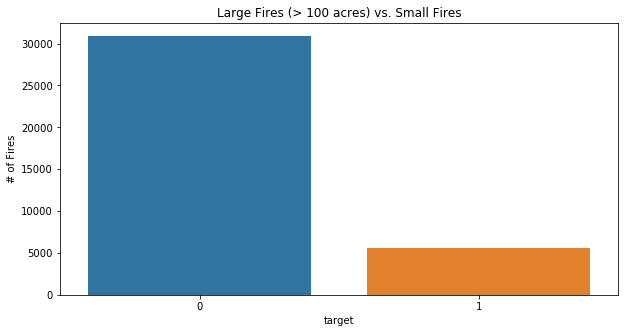

In [10]:
plt.figure(figsize=(10,5))
sns.countplot(df['target'])
plt.title('Large Fires (> 100 acres) vs. Small Fires')
plt.ylabel('# of Fires')
plt.show()

In [11]:
df.describe()

,fire_size,latitude,longitude,Vegetation,Temp_pre_30,Temp_pre_15,Temp_pre_7,Wind_pre_30,Wind_pre_15,Wind_pre_7,Hum_pre_30,Hum_pre_15,Hum_pre_7,Prec_pre_30,Prec_pre_15,Prec_pre_7,remoteness,target
count,36535.000000,36535.000000,36535.000000,36535.000000,36535.000000,36535.000000,36535.000000,36535.000000,36535.000000,36535.000000,36535.000000,36535.000000,36535.000000,36535.000000,36535.000000,36535.000000,36535.000000,36535.000000
mean,2333.094280,36.660711,-95.897825,11.043602,60.836480,61.780976,62.454035,3.142058,3.129052,3.104218,58.613043,57.609115,56.462198,39.472134,17.989741,7.496871,0.244771,0.153989
std,15370.623847,6.901523,16.099409,5.584928,15.342448,15.073362,15.131889,1.200735,1.248833,1.332299,17.258248,17.601590,18.070949,135.670076,69.206011,38.111117,0.147181,0.360943
min,0.510000,17.958364,-165.116700,0.000000,6.510518,0.736096,-5.522988,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.150000,32.446761,-104.761750,9.000000,49.089291,50.133548,50.828285,2.333406,2.285050,2.202799,53.025187,51.308131,48.821073,0.000000,0.000000,0.000000,0.140430,0.000000
50%,4.000000,34.815135,-93.251333,12.000000,60.906686,61.827082,62.792857,3.062696,3.044966,2.997159,63.548101,62.273349,60.682353,3.000000,0.000000,0.000000,0.210037,0.000000
75%,21.000000,40.335693,-83.646370,15.000000,73.949175,74.615478,75.221471,3.864361,3.872146,3.883929,69.784996,69.284457,68.708757,43.500000,15.600000,2.500000,0.294780,0.000000
max,538049.000000,69.047200,-65.417709,16.000000,115.880000,124.822034,131.000000,25.700000,25.700000,25.700000,94.000000,94.000000,96.000000,13560.800000,2527.000000,1638.000000,1.000000,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd19dafbc88>,
      dtype=object)

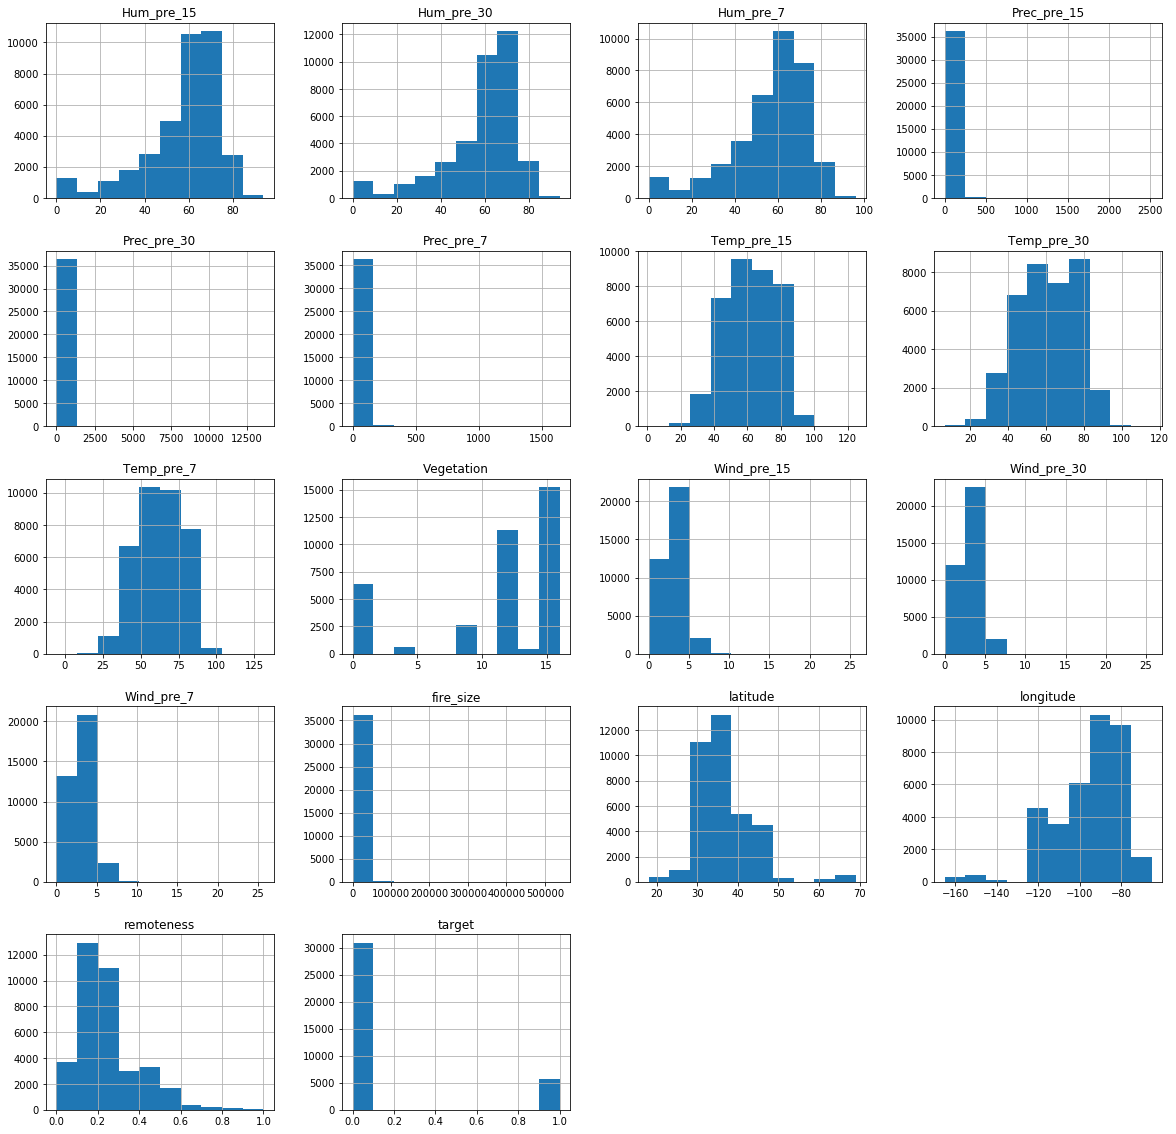

In [12]:
df.hist(figsize=(20,20))

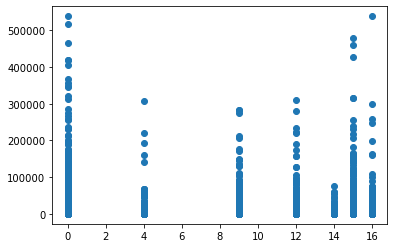

In [13]:
plt.scatter(df['Vegetation'], df['fire_size'])

#### Hum_cont v Fire_Size

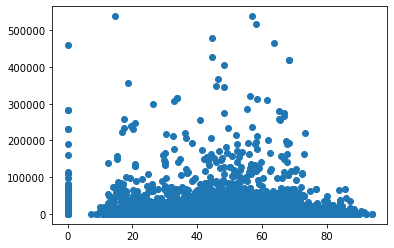

In [14]:
plt.scatter(df['Hum_pre_30'], df['fire_size'])

#### Prec-cont vs Fire_Size

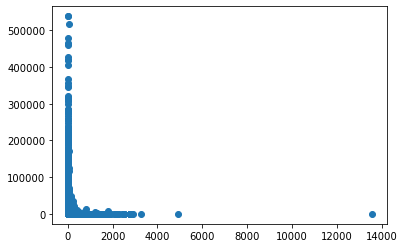

In [15]:
plt.scatter(df['Prec_pre_30'], df['fire_size'])

#### Temp_cont vs. Fire_Size

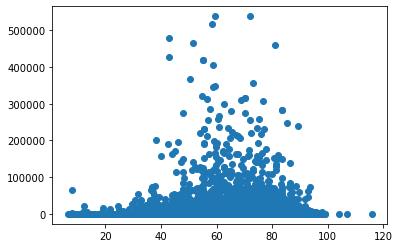

In [16]:
plt.scatter(df['Temp_pre_30'], df['fire_size'])

#### Wind_cont vs. Fire_Size

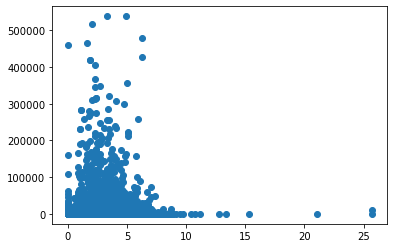

In [17]:
plt.scatter(df['Wind_pre_30'], df['fire_size'])

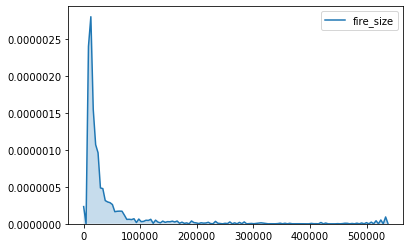

In [18]:
# spread of fires by acres burned, play with the Xlim to see more or less of the distribution
sns.kdeplot(df['fire_size'], shade=True)#.set_xlim(0,50000)

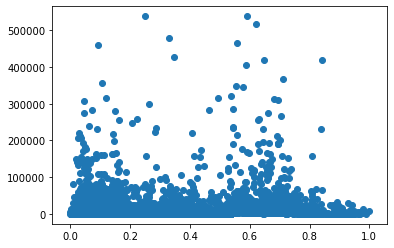

In [19]:
plt.scatter(df['remoteness'],df['fire_size'])

### Target Visuals

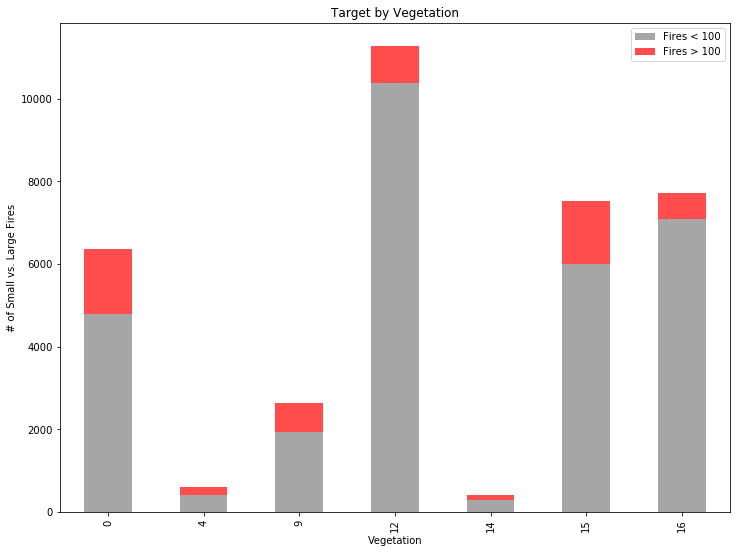

In [20]:
vegetation_viz = df.groupby(['Vegetation', 'target']).Vegetation.count().unstack()

p1 = vegetation_viz.plot(kind='bar', stacked=True, title='Target by Vegetation', color=['grey', 'red'], alpha=.70, figsize=(12,9))
p1.set_xlabel('Vegetation')
p1.set_ylabel('# of Small vs. Large Fires')
p1.legend(['Fires < 100', 'Fires > 100'])
plt.show()

**Vegetation**

0: Unknown

4: Temperate Evergreen Needleleaf Forest

9: C3 Grassland/Steppe

12: Open Shrubland

14: Desert

15: Polar Desert/Rock/Ice

16: Secondary Tropical Evergreen Broadleaf Forest

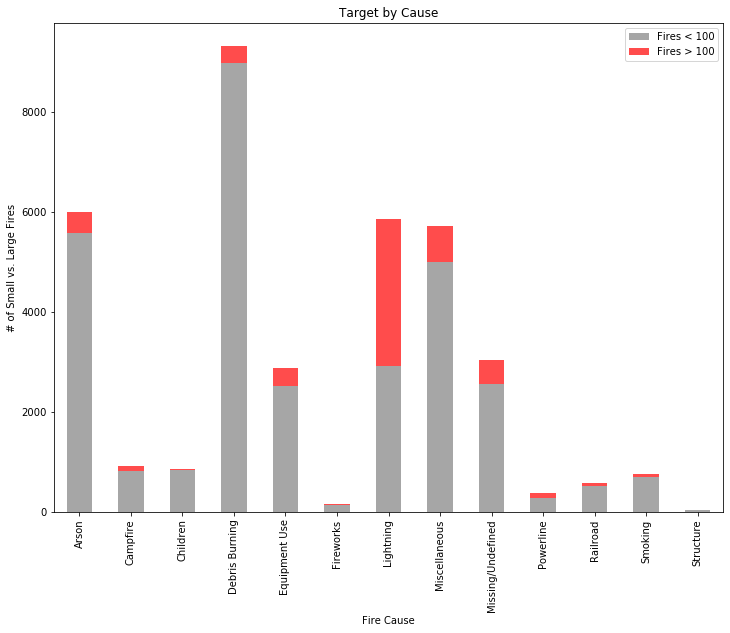

In [21]:
cause_viz = df.groupby(['stat_cause_descr', 'target']).stat_cause_descr.count().unstack()

p2 = cause_viz.plot(kind='bar', stacked=True, title='Target by Cause', color=['grey', 'red'], alpha=.70, figsize=(12,9))
p2.set_xlabel('Fire Cause')
p2.set_ylabel('# of Small vs. Large Fires')
p2.legend(['Fires < 100', 'Fires > 100'])
plt.show()

In [22]:
df['month'] = df['discovery_month'].apply(lambda x: 
                                         1 if x == 'Jan'
                                          else 2 if x == 'Feb'
                                          else 3 if x == 'Mar'
                                          else 4 if x == 'Apr'
                                          else 5 if x == 'May'
                                          else 6 if x == 'Jun'
                                          else 7 if x == 'Jul'
                                          else 8 if x == 'Aug'
                                          else 9 if x == 'Sep'
                                          else 10 if x == 'Oct'
                                          else 11 if x == 'Nov'
                                          else 12
                                         )

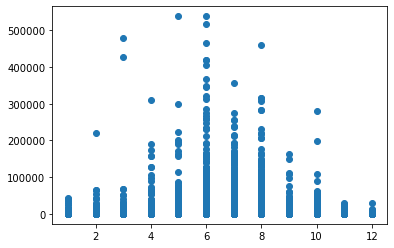

In [23]:
plt.scatter(df['month'], df['fire_size'])

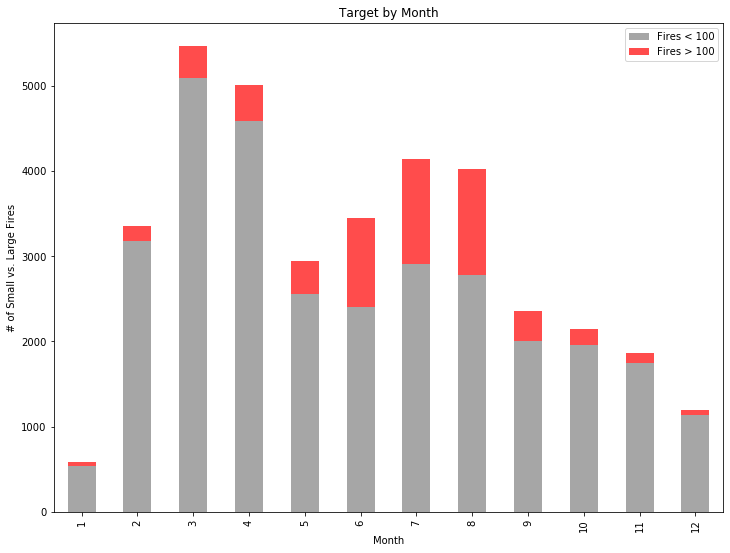

In [24]:
#### JUN/JUL/AUG have the most big fires out of the year ####

month_viz = df.groupby(['month', 'target']).month.count().unstack()

p3 = month_viz.plot(kind='bar', stacked=True, title='Target by Month', color=['grey', 'red'], alpha=.70, figsize=(12,9))
p3.set_xlabel('Month')
p3.set_ylabel('# of Small vs. Large Fires')
p3.legend(['Fires < 100', 'Fires > 100'])
plt.show()

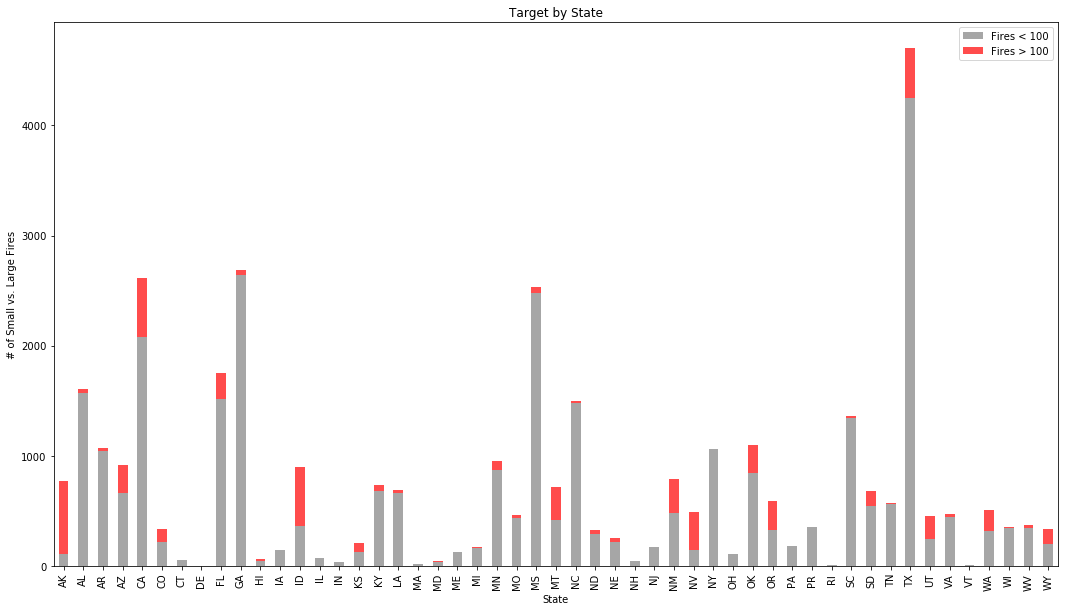

In [25]:
state_viz = df.groupby(['state', 'target']).state.count().unstack()

p4 = state_viz.plot(kind='bar', stacked=True, title='Target by State', color=['grey', 'red'], alpha=.70, figsize=(18,10))
p4.set_xlabel('State')
p4.set_ylabel('# of Small vs. Large Fires')
p4.legend(['Fires < 100', 'Fires > 100'])
plt.show()

In [26]:
df['year'] = df['disc_clean_date'].apply(lambda x: int(x[-4:]))

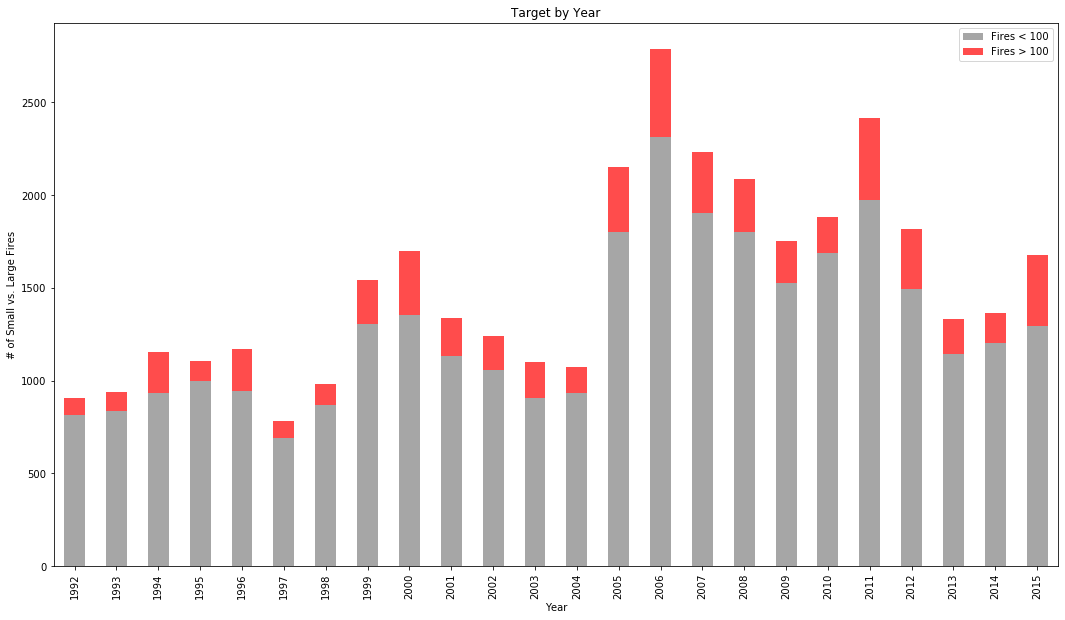

In [27]:
year_viz = df.groupby(['year', 'target']).year.count().unstack()

p5 = year_viz.plot(kind='bar', stacked=True, title='Target by Year', color=['grey', 'red'], alpha=.70, figsize=(18,10))
p5.set_xlabel('Year')
p5.set_ylabel('# of Small vs. Large Fires')
p5.legend(['Fires < 100', 'Fires > 100'])
plt.show()

In [28]:
# df.groupby('year')['target'].value_counts(normalize=True)  # 2015 was the only year that Big fires made up >20% of fires

## Feature Engineering

#### [cold_front'] 
(http://www.nationalfirefighter.com/blog/Effects-of-Weather-Conditions-on-Wildfire-Suppression)

In [29]:
df['temp_avg'] = (df['Temp_pre_30']+df['Temp_pre_15']+df['Temp_pre_7'])/3

In [30]:
df[['Temp_pre_30', 'Temp_pre_15', 'Temp_pre_7', 'temp_avg']].describe()

,Temp_pre_30,Temp_pre_15,Temp_pre_7,temp_avg
count,36535.000000,36535.000000,36535.000000,36535.000000
mean,60.836480,61.780976,62.454035,61.690497
std,15.342448,15.073362,15.131889,14.995829
min,6.510518,0.736096,-5.522988,1.892735
25%,49.089291,50.133548,50.828285,50.112659
50%,60.906686,61.827082,62.792857,61.704819
75%,73.949175,74.615478,75.221471,74.558734
max,115.880000,124.822034,131.000000,119.156065


#### ['is_remote']

In [31]:
df['is_remote'] = np.where(df['remoteness'] > 0.5,1,0)

#### [ 'did_rain']

In [32]:
cond = [
    (df['Prec_pre_7'] != 0) | (df['Prec_pre_15'] != 0) | (df['Prec_pre_30'] != 0)
]
choice = [
    1
]
df['did_rain'] = np.select(cond,choice,default=0)

#### ['binning_temp']

#### Dummy Dataframe

In [34]:
df.Vegetation = df.Vegetation.astype('O')

dummies = ['discovery_month', 'state', 'Vegetation']

df = pd.get_dummies(df, columns=dummies, drop_first=True) # adds 67 columns, and we remove the 3 originals, total of 64 dummy columns

#### ['binning_longitude']

#### ['west_coast']

#### ['is_very_windy']

In [39]:
df['Hum_pre_30'].head()

0    78.216590
1    70.840000
2    75.531629
3    44.778429
7    72.899478
Name: Hum_pre_30, dtype: float64

#### ['is_humid']

In [41]:
df['is_humid'] = np.where((df['Hum_pre_30'] > 50) | (df['Hum_pre_15'] > 50) | (df['Hum_pre_7'] > 50),1,0)

## Models

In [ ]:
# fitting all 3 models
X = df[final_features]
y = df['default']
# train test split + scaler info
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

scaler = StandardScaler()  
scaler.fit(X_train)

X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test)

### KNN

In [ ]:
def KnnTest(input_x,input_y):
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(input_x,input_y)
    pred_train = knn.predict(input_x)
    score = f1_score(input_y,pred_train,zero_division=1)
    return score

In [ ]:
# KNN
knn = KNeighborsClassifier(n_neighbors=1,algorithm='auto',weights='uniform')

knn.fit(X_train, y_train)

y_pred_train = knn.predict(X_train)

y_pred_test = knn.predict(X_test)

### Logistic Regression

In [ ]:
def LogRegTest(input_x,input_y):
    lr = LogisticRegression(random_state=1,C=1e9)
    lr.fit(input_x,input_y)
    pred_train = lr.predict(input_x)
    score = f1_score(input_y,pred_train,zero_division=1)
    return score

In [ ]:
# Logistic Regression
lr = LogisticRegression(random_state=2,C=1e9,class_weight='balanced',penalty='l2')

lr.fit(X_train,y_train)

pred_train = lr.predict(X_train)

pred_test = lr.predict(X_test)

### Decision Tree

In [ ]:
def DTreeTest(input_x,input_y):
    tree = DecisionTreeClassifier()
    tree.fit(input_x,input_y)
    pred_train = tree.predict(input_x)
    score = f1_score(input_y,pred_train,zero_division=1)
    return score

In [ ]:
#Decision Tree
tree = DecisionTreeClassifier(max_depth=12, min_samples_split=17,criterion='gini',min_samples_leaf=4)

tree = tree.fit(X_train,y_train)

pred_train = tree.predict(X_train)

pred_test = tree.predict(X_test)